In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

In [48]:
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule
from deeptime.covariance import KoopmanWeightingEstimator

filenames = [ "COLVAR" ]

# load file
df = load_dataframe(filenames,start=0,stop=70000)

# get descriptors
X = df.filter(regex='p.x|p.y').values

#get time
t = df['time'].values

#lag_time
lag_time = 100

#Koopman Reweighting
koopman_estimator = KoopmanWeightingEstimator(lagtime=lag_time)
reweighting_model = koopman_estimator.fit(X).fetch_model()
weights = reweighting_model.transform(X)
print(weights)
logweights = np.log(weights)
print(logweights)
# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,logweights=logweights,reweight_mode="weights_t")
#tprime = t is needed to ensure that the time is not rescaled by the weight


# create datamodule
datamodule = DictModule(dataset,lengths=[0.8,0.2])#,random_split=False,shuffle=False)

print(X.shape)

[0.93813469 0.9452767  0.94831128 ... 1.07017358 1.07353217 1.07815452]
[-0.06386174 -0.05627759 -0.05307248 ...  0.06782086  0.07095431
  0.0752508 ]


/Users/dhimanray/miniconda3/lib/python3.12/site-packages/mlcolvar/utils/timelagged.py:140: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn(


(70000, 2)


(70000, 2)
(70000,)
(70000,)


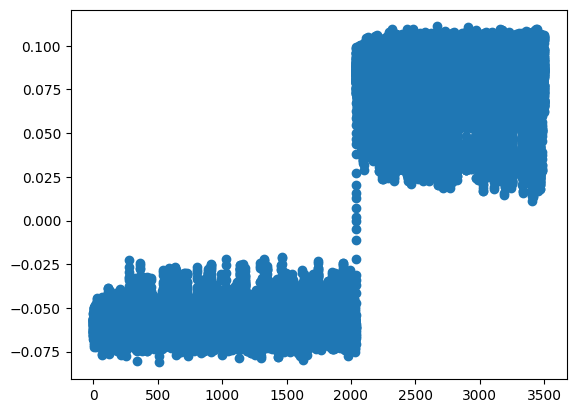

In [49]:
print(X.shape)
print(t.shape)
print(logweights.shape)

import matplotlib.pyplot as plt
plt.scatter(t,logweights)

In [50]:
from mlcolvar.cvs import DeepTICA

n_components = 1
nn_layers = [2, 15, 15, 1]
options= {'nn': {'activation': 'shifted_softplus'} }

model = DeepTICA(nn_layers, n_cvs=n_components, options=options)
#model.loss_fn.n_eig = n_components

model

DeepTICA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=15, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=15, out_features=1, bias=True)
    )
  )
  (tica): TICA(in_features=1, out_features=1)
)

In [51]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
torch.set_float32_matmul_precision('medium')
trainer.fit( model, datamodule )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/dhimanray/miniconda3/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name    | Type                  | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------------------
0 | loss_fn | ReduceEigenvaluesLoss | 0      | train | ?        | ?        
1 | norm_in | Normalization         | 0      | train | [1, 2]   | [1, 2]   
2 | nn      | FeedForward           | 301    | train | [1, 2]   | [1, 1]   
3 | tica    | TICA                  | 0      | train | [1, 1]   | [1, 1]   
---------------------------------------------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)
10   

Sanity Checking: |                                                                 | 0/? [00:00<?, ?it/s]

/Users/dhimanray/miniconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                                      | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.12it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.64it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.28it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.50it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.77it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.84it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.78it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.50it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.69it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.00it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.02it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.32it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 103: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.64it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 104: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.14it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 105: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.08it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 106: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.75it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 107: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 113: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.98it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 114: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.17it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 115: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.27it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 116: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.99it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 117: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 123: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.81it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 124: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.35it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 125: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.04it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 126: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.12it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 127: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 134: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 126.53it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.69it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 136: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.95it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 137: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 135.78it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 138: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 144: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.99it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 145: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.16it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 146: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.03it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 147: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.88it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 148: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 154: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.32it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 155: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.75it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 156: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.78it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 157: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 145.50it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 158: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 164: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.84it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 165: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.37it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 166: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.92it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 167: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.00it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 168: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 175: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.31it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 176: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.58it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 177: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.80it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 178: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.53it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 179: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 185: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.90it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 186: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.17it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 187: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.74it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 188: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.75it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 189: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 195: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.37it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 196: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.92it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 197: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.34it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 198: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.98it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 199: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 205: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 144.21it/s, v_num=18]
Validation: 0it [00:00, ?it/s]
Epoch 205: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.47it/s, v_num=18]


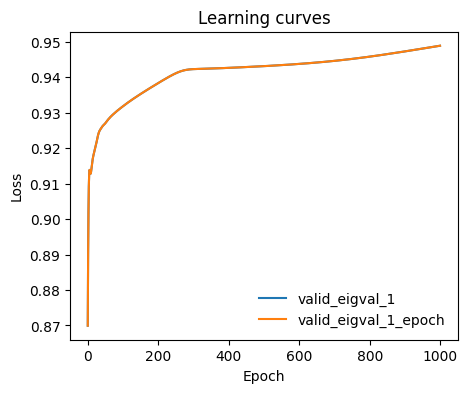

In [52]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

In [53]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) )
model.postprocessing = norm
#print(Statistics(s))

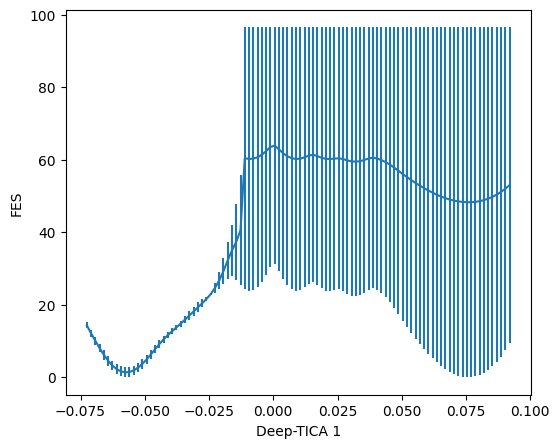

In [54]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)
if n_components == 1:
    axs = [axs]

for i in range(n_components):
    # restrict the second CV to the points in which the first is < 0
    fes,grid,bounds,error = compute_fes(s[:,i],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

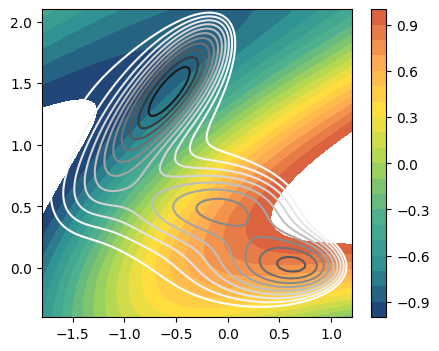

In [55]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]

    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=np.linspace(-1.,1.,21), ax=ax)
    #ax.scatter(X[:,0],X[:,1],s=1, alpha=0.2,c='w')

In [56]:
model.to_torchscript(file_path='deeptica_with_koopman_lag100_trans1.ptc',method='trace')

/Users/dhimanray/miniconda3/lib/python3.12/site-packages/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()


DeepTICA(
  original_name=DeepTICA
  (loss_fn): ReduceEigenvaluesLoss(original_name=ReduceEigenvaluesLoss)
  (norm_in): Normalization(original_name=Normalization)
  (nn): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): Shifted_Softplus(original_name=Shifted_Softplus)
      (2): Linear(original_name=Linear)
      (3): Shifted_Softplus(original_name=Shifted_Softplus)
      (4): Linear(original_name=Linear)
    )
  )
  (tica): TICA(original_name=TICA)
  (postprocessing): Normalization(original_name=Normalization)
)